<a name="pagetop"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Upper Air and the Skew-T Log-P</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_Advanced_Sounding_001.png" alt="Example Skew-T" style="height: 500px;"></div>

### Questions
1. Where can upper air data be found and what format is it in?
1. How can I obtain upper air data programatically?
1. How can MetPy be used to make a Skew-T Log-P diagram and associated fiducial lines?
1. How are themodynamic calculations performed on upper-air data?

### Table of Contents
1. <a href="#upperairdata">Obtain upper air data</a>
1. <a href="#makeskewt">Make a Skew-T</a>
1. <a href="#thermo">Thermodynamics</a>
1. <a href="#hodograph">Plotting a Hodograph</a>
1. <a href="#advanced">Advanced Layout</a>

Adopted from https://unidata.github.io/python-training/workshop/Skew_T/skewt-and-hodograph/.

<hr style="height:2px;">

<a name="upperairdata"></a>
## 1. Obtain upper air data

### Overview
Upper air observations are generally reported as a plain text file in a tabular format that represents the down sampled raw data transmitted by the rawinsonde. Data are reported an mandatory levels and at levels of significant change. An example of sounding data may look like this:

```
-----------------------------------------------------------------------------
   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV
    hPa     m      C      C      %    g/kg    deg   knot     K      K      K 
-----------------------------------------------------------------------------
 1000.0    270                                                               
  991.0    345   -0.3   -2.8     83   3.15      0      0  273.6  282.3  274.1
  984.0    403   10.2   -7.8     27   2.17    327      4  284.7  291.1  285.0
  963.0    581   11.8   -9.2     22   1.99    226     17  288.0  294.1  288.4
  959.7    610   11.6   -9.4     22   1.96    210     19  288.1  294.1  288.5
  ```
  
Data are available to download from the [University of Wyoming archive](http://weather.uwyo.edu/upperair/sounding.html), the [Iowa State archive](https://mesonet.agron.iastate.edu/archive/raob/), and the [Integrated Global Radiosonde Archive (IGRA)](https://www.ncdc.noaa.gov/data-access/weather-balloon/integrated-global-radiosonde-archive). **There is no need to download data manually.** We can use the siphon library (also developed at Unidata) to request and download these data. Be sure to checkout the [documentation](https://unidata.github.io/siphon/latest/api/index.html) on all of siphon's capabilities.

### Getting our data
First, we need to create a `datetime` object that has the time of observation we are looking for. We can then request the data for a specific station. Note that if you provide an invalid time or station where no sounding data are present you will receive an error.

In [1]:
# Create a datetime for our request - notice the times are from laregest (year) to smallest (hour)
from datetime import datetime
request_time = datetime(1999, 5, 3, 12)

In [2]:
# Store the station name in a variable for flexibility and clarity
station = 'OUN'

In [3]:
# Import the Wyoming simple web service and request the data
# Don't worry about a possible warning from Pandas - it's related to our handling of units
from siphon.simplewebservice.wyoming import WyomingUpperAir
df = WyomingUpperAir.request_data(request_time, station)

In [4]:
# Let's see what we got in return
df.head()

pressure  height  temperature  dewpoint  direction  speed        u_wind  \
0     966.0     345         18.2      16.9      180.0   15.0 -1.836970e-15   
1     937.2     610         16.8      15.9      190.0   27.0  4.688501e+00   
2     925.0     725         16.2      15.5      195.0   31.0  8.023390e+00   
3     904.6     914         15.1      14.2      205.0   34.0  1.436902e+01   
4     872.6    1219         13.3      12.1      210.0   38.0  1.900000e+01   

      v_wind station  station_number                time  latitude  longitude  \
0  15.000000     OUN           72357 1999-05-03 12:00:00     35.18     -97.44   
1  26.589809     OUN           72357 1999-05-03 12:00:00     35.18     -97.44   
2  29.943701     OUN           72357 1999-05-03 12:00:00     35.18     -97.44   
3  30.814465     OUN           72357 1999-05-03 12:00:00     35.18     -97.44   
4  32.908965     OUN           72357 1999-05-03 12:00:00     35.18     -97.44   

   elevation     pw  
0      345.0  20.54  
1      345.0  20.54  
2      345.0  20.54  
3      345.0  20.54  
4      345.0  20.54

We got a Pandas dataframe back, which is great. Sadly, Pandas does not play well with units, so we need to attach units and make some other kind of data structure. We've provided a helper function for this - it takes the dataframe with our special `.units` attribute and returns a dictionary where the keys are column (data series) names and the values are united arrays. This means we can still use the dictionary access syntax and mostly forget that it is not a data frame any longer.

Fist, let's look at the special attribute siphon added:

In [5]:
df.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

Now let's import the helper and the units registry from MetPy and get units attached.

In [6]:
from metpy.units import pandas_dataframe_to_unit_arrays, units
sounding = pandas_dataframe_to_unit_arrays(df)

In [7]:
sounding

{'pressure': array([966. , 937.2, 925. , 904.6, 872.6, 853. , 850. , 836. , 821. ,
        811.6, 782.3, 754.2, 726.9, 700. , 648.9, 624.6, 601.1, 595. ,
        587. , 576. , 555.7, 534.2, 524. , 500. , 473.3, 400. , 384.5,
        358. , 343. , 308.3, 300. , 276. , 273. , 268.5, 250. , 244.2,
        233. , 200. , 191.8, 190. , 174.2, 168. , 151. , 150. , 144. ,
        130.6, 118.4, 105. , 102.2, 100. ,  97.3,  94.7,  80.6,  76. ,
         73.7,  70. ,  61.8,  50. ,  48.6,  44.1,  34.6,  30. ,  29.9,
         26.4,  21.4,  20. ,  16.9,  16.2,  16.1,  15.4,  13.7,  11.3,
         10.7,  10.2,  10. ,   9.9]) <Unit('hectopascal')>,
 'height': array([  345,   610,   725,   914,  1219,  1411,  1441,  1581,  1734,
         1829,  2134,  2438,  2743,  3056,  3658,  3962,  4267,  4348,
         4453,  4600,  4877,  5182,  5331,  5690,  6096,  7340,  7620,
         8124,  8421,  9144,  9330,  9880,  9951, 10058, 10520, 10668,
        10967, 11930, 12192, 12252, 12802, 13032, 13716, 13760, 14

<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="makeskewt"></a>
## 2.Make a Skew-T
Now that we have data, we can actually start making our Skew-T Log-P diagram. This consists of:

* Import matplotlib
* Importing the SkewT object
* Creating a figure
* Creating a SkewT object based upon that figure
* Plotting our data

In [8]:
import matplotlib.pyplot as plt
from metpy.plots import SkewT
%matplotlib inline

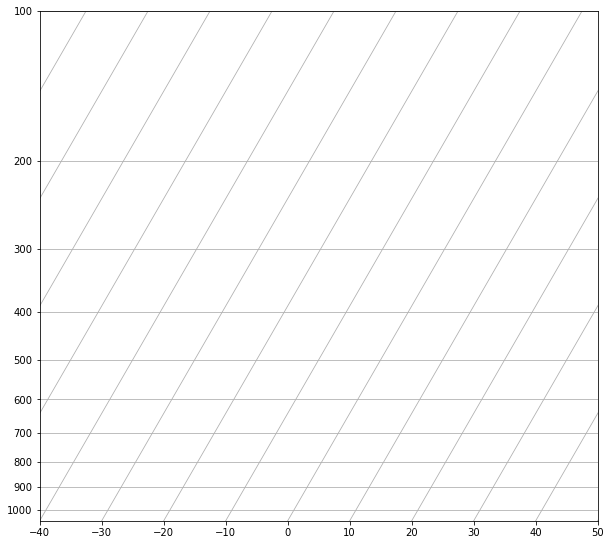

In [9]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

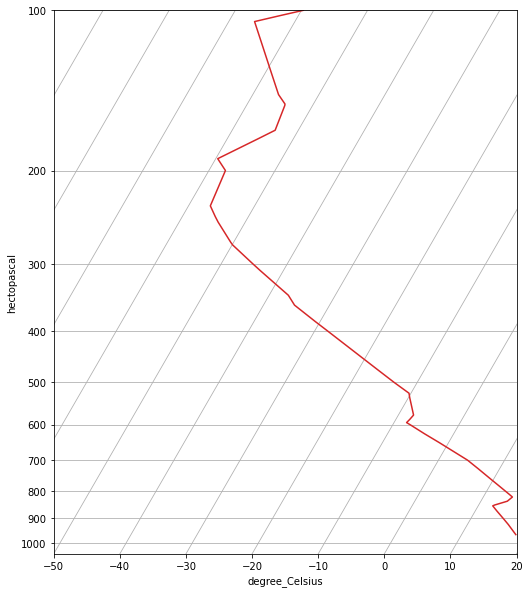

In [10]:
# Plot the data using normal plotting functions, all of the transforms
# happen in the background!
skew.plot(sounding['pressure'], sounding['temperature'], color='tab:red')
skew.ax.set_ylim(1050,100)
skew.ax.set_xlim(-50,20)
# Redisplay the figure
fig

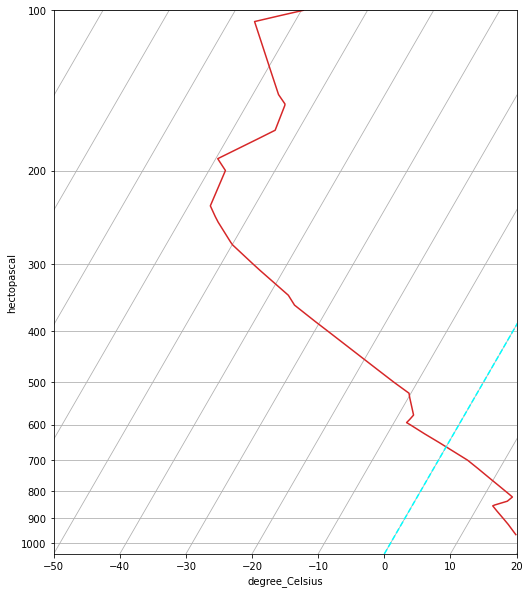

In [11]:
# Plot a isotherm using axvline (axis vertical line)
skew.ax.axvline(0 * units.degC, color='cyan', linestyle='--')

# Redisplay the figure
fig

<div class="alert alert-success">
    <b>EXERCISE Part 1</b>:
     <ul>
         <li>Download your own data using the Wyoming upper-air archive. Have a look at the <a href="https://unidata.github.io/siphon/latest/api/simplewebservice.html#module-siphon.simplewebservice.wyoming">documentation</a> to help get started.</li>
         <li>Attach units using the unit helper.</li>
    </ul>
</div>

In [12]:
# Import the Wyoming simple web service upper air object
# YOUR CODE GOES HERE

In [13]:
# Create the datetime and station variables you'll need
# YOUR CODE GOES HERE

In [14]:
# Make the request for the data - assign it to a dataframe called my_df
# YOUR CODE GOES HERE

In [15]:
# Attach units to the data - assign it to the variable my_sounding
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [16]:
# %load solutions/skewt_get_data.py

# Cell content replaced by load magic replacement.
# Import the Wyoming simple web service upper air object
from siphon.simplewebservice.wyoming import WyomingUpperAir

# Create the datetime and station variables you'll need
request_time = datetime(2011, 4, 14, 18)
station = 'OUN'

# Make the request for the data
my_df = WyomingUpperAir.request_data(request_time, station)

# Attach units to the data
my_sounding = pandas_dataframe_to_unit_arrays(my_df)


<div class="alert alert-success">
    <b>EXERCISE Part 2</b>:
     <ul>
         <li>Make a figure and SkewT object.</li>
         <li>Plot the temperature and dewpoint in red and green lines.</li>
         <li>Set the axis limits to sensible limits with set_xlim and set_ylim.</li>
    </ul>
</div>

In [17]:
# Make a figure called my_fig

# Make a SkewT object called my_skew

# Plot the temperature and dewpoint


<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

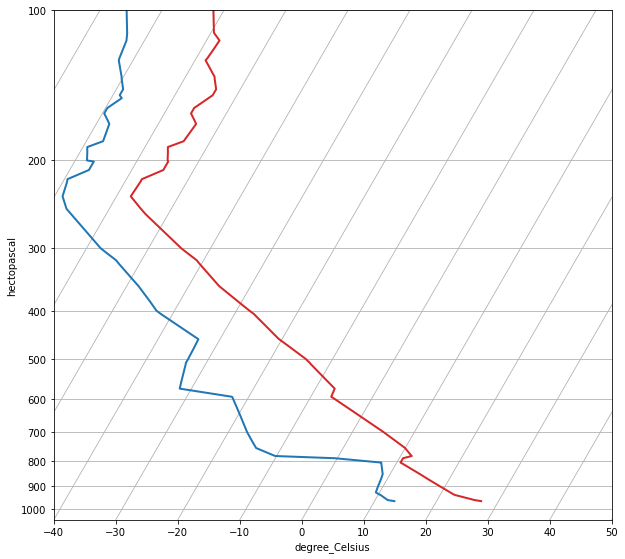

In [18]:
# %load solutions/skewt_make_figure.py

# Cell content replaced by load magic replacement.
# Make a figure
my_fig = plt.figure(figsize=(10, 10))

# Make a SkewT object
my_skew = SkewT(my_fig)

# Plot the temperature and dewpoint
my_skew.plot(my_sounding['pressure'], my_sounding['temperature'], linewidth=2, color='tab:red')
my_skew.plot(my_sounding['pressure'], my_sounding['dewpoint'], linewidth=2, color='tab:blue')


<div class="alert alert-success">
    <b>EXERCISE Part 3</b>:
     <ul>
         <li>Plot wind barbs using the plot_barbs method of the SkewT object.</li>
         <li>Add the fiducial lines for dry adiabats, moist adiabats, and mixing ratio lines using the plot_dry_adiabats(), plot_moist_adiabats(), plot_mixing_lines() functions. </li>
    </ul>
</div>

In [19]:
# Plot wind barbs

# Add dry adiabats

# Add moist adiabats

# Add mixing ratio lines

# Redisplay figure


<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

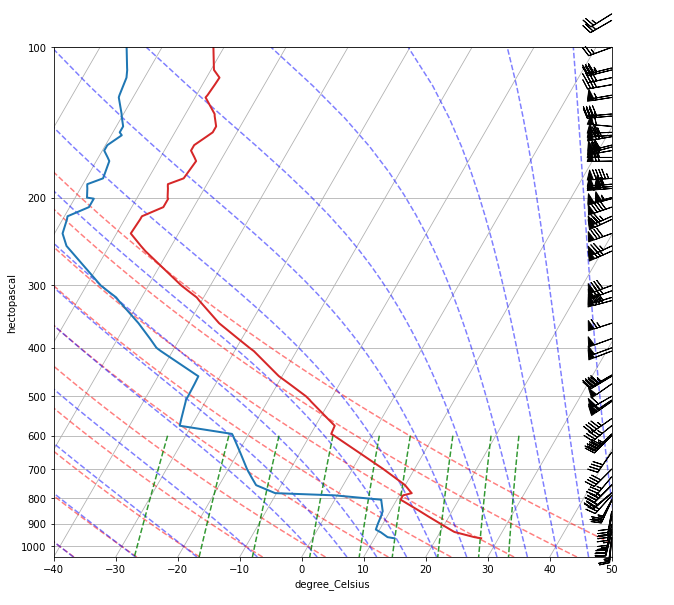

In [20]:
# %load solutions/skewt_wind_fiducials.py

# Cell content replaced by load magic replacement.
# Plot wind barbs
my_skew.plot_barbs(my_sounding['pressure'], my_sounding['u_wind'], my_sounding['v_wind'])

# Add dry adiabats
my_skew.plot_dry_adiabats()

# Add moist adiabats
my_skew.plot_moist_adiabats()

# Add mixing ratio lines
my_skew.plot_mixing_lines()

# Redisplay figure
my_fig


<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="thermo"></a>
## 3.Thermodynamics

Using MetPy's calculations functions we can calculate thermodynamic paramters like LCL, LFC, EL, CAPE, and CIN. Let's start off with the LCL.

In [21]:
# Add the dewpoint line to our plot we were working with
skew.plot(sounding['pressure'], sounding['dewpoint'], linewidth=2, color='tab:blue')

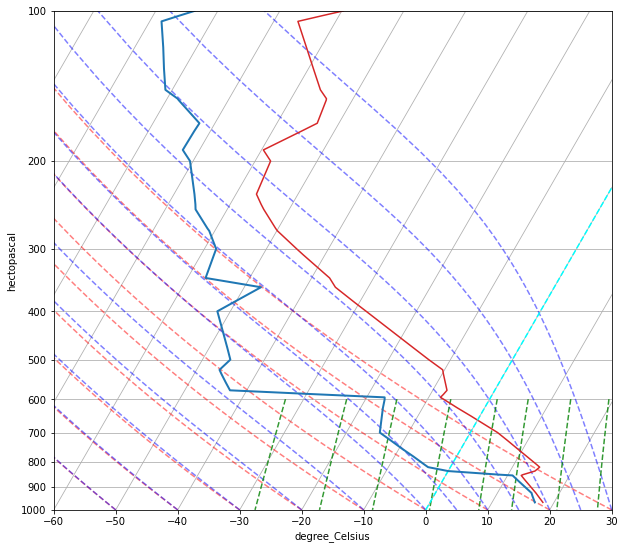

In [22]:
# Get our basic plot we were working with ready to plot new things on

# Set some good axis limits
skew.ax.set_xlim(-60, 30)
skew.ax.set_ylim(1000, 100)

# Add relevant fiducial lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

fig

In [23]:
import metpy.calc as mpcalc

In [24]:
lcl_pressure, lcl_temperature = mpcalc.lcl(sounding['pressure'][0],
                                           sounding['temperature'][0],
                                           sounding['dewpoint'][0])
print(lcl_pressure, lcl_temperature)

947.5117804436877 hectopascal 16.595809056878068 degree_Celsius


We can this as a point on our sounding using the `scatter` method.

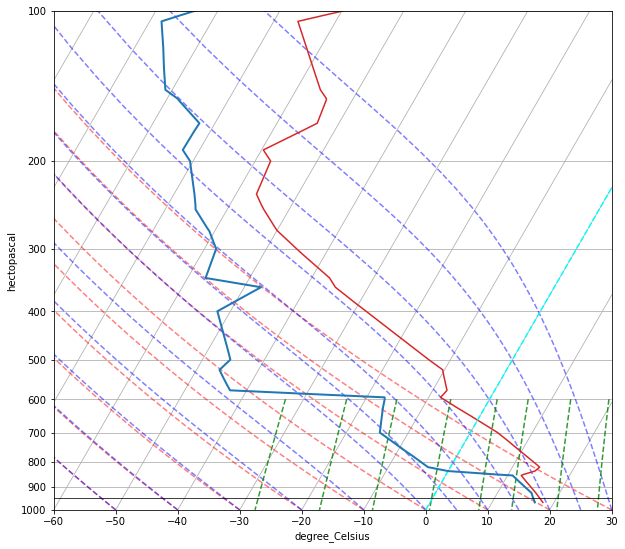

In [25]:
skew.ax.axhline(y=lcl_pressure, color='k', linewidth=0.75)
fig

We can also calculate the ideal parcel profile and plot it.

In [26]:
sounding['profile'] = mpcalc.parcel_profile(sounding['pressure'], sounding['temperature'][0], sounding['dewpoint'][0])
print(sounding['profile'])

[291.34999999999997 289.332649213254 288.8361363433054 287.9864847695152 286.60149471032065 285.71932649391397 285.5818991145438 284.93180665091165 284.21869028700434 283.7626796688801 282.2933481150177 280.8104574071829 279.293204429722 277.7162990774359 274.4630378139657 272.77936155160705 271.05445525756346 270.5898609153392 269.9694008355659 269.0947618058378 267.4110104883888 265.52034776820005 264.58129311563033 262.2544016836624 259.4509203554703 250.31238672389708 248.05292285637083 243.87581821630778 241.32164250850158 234.8365672649519 233.1583902213168 228.01084832457497 227.33548801023284 226.30871668805716 221.90943246065845 220.46918074138492 217.601719896205 208.43725244710154 205.97720658196795 205.42651772720927 200.4165035263958 198.35826290117149 192.41430984755297 192.0498144319888 189.8251458311549 184.60416296658585 179.50478125334087 173.44997953039478 172.1157563121204 171.04898745116725 169.71659561468758 168.40834081714823 160.82723854891609 158.14948831617275

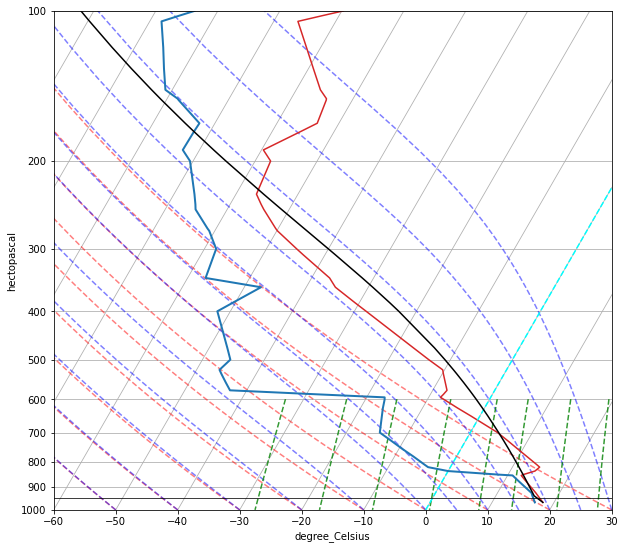

In [27]:
# Plot the profile
skew.plot(sounding['pressure'], sounding['profile'], color='black')

# Redisplay the figure
fig

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>Calculate the LFC and EL for the sounding.</li>
         <li>Plot them as horizontal line markers.</li>
    </ul>
</div>

In [28]:
# Calculate the LFC
# YOUR CODE GOES HERE

# Calculate the EL
# YOUR CODE GOES HERE

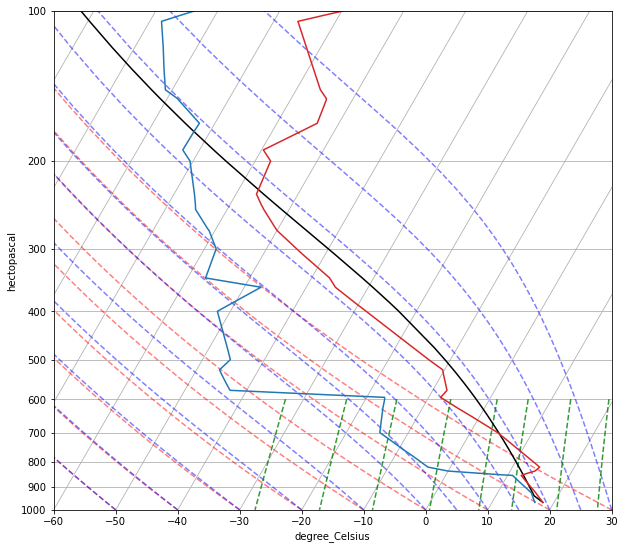

In [29]:
# Create a new figure and SkewT object
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

# Plot the profile and data
skew.plot(sounding['pressure'], sounding['profile'], color='black')
skew.plot(sounding['pressure'], sounding['temperature'], color='tab:red')
skew.plot(sounding['pressure'], sounding['dewpoint'], color='tab:blue')

# Plot the LCL, LFC, and EL as horizontal lines
# YOUR CODE GOES HERE

# Set axis limits
skew.ax.set_xlim(-60, 30)
skew.ax.set_ylim(1000, 100)

# Add fiducial lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [30]:
# %load solutions/skewt_thermo.py

# Cell content replaced by load magic replacement.
# Get data for the sounding
df = WyomingUpperAir.request_data(datetime(1999, 5, 3, 12), 'OUN')

# Calculate the ideal surface parcel path
sounding['profile'] = mpcalc.parcel_profile(sounding['pressure'],
                                            sounding['temperature'][0],
                                            sounding['dewpoint'][0]).to('degC')

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(sounding['pressure'][0],
                                           sounding['temperature'][0],
                                           sounding['dewpoint'][0])

# Calculate the LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(sounding['pressure'],
                                           sounding['temperature'],
                                           sounding['dewpoint'])

# Calculate the EL
el_pressure, el_temperature = mpcalc.el(sounding['pressure'],
                                        sounding['temperature'],
                                        sounding['dewpoint'])

print(lcl_pressure, lcl_temperature)
print(lfc_pressure, lfc_temperature)
print(el_pressure, el_temperature)
lcl_pressure.shape
sounding['pressure'][0].shape

947.5117804436877 hectopascal 16.595809056878068 degree_Celsius
705.3534496823725 hectopascal 4.884899017330216 degree_Celsius
228.15152422388618 hectopascal -56.81015356597061 degree_Celsius


()

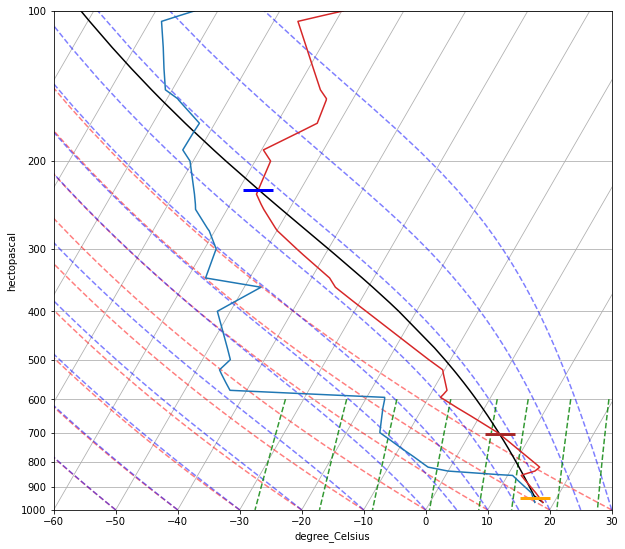

In [31]:
# Create a new figure and SkewT object
fig = plt.figure(figsize=(10, 10))
skew = SkewT(fig)

# Plot the profile and data
skew.plot(sounding['pressure'], sounding['profile'], color='black')
skew.plot(sounding['pressure'], sounding['temperature'], color='tab:red')
skew.plot(sounding['pressure'], sounding['dewpoint'], color='tab:blue')

# Plot the LCL, LFC, and EL as horizontal markers
if lcl_pressure:
    skew.ax.plot(lcl_temperature, lcl_pressure, marker="_", color='orange', markersize=30, markeredgewidth=3)
    
if lfc_pressure:
    skew.ax.plot(lfc_temperature, lfc_pressure, marker="_", color='brown', markersize=30, markeredgewidth=3)
    
if el_pressure:
    skew.ax.plot(el_temperature, el_pressure, marker="_", color='blue', markersize=30, markeredgewidth=3)

# Set axis limits
skew.ax.set_xlim(-60, 30)
skew.ax.set_ylim(1000, 100)

# Add fiducial lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

<div class="alert alert-success">
    <b>BONUS</b>:
     <ul>
         <li>Use the function surface_based_cape_cin in the MetPy calculations module to calculate the CAPE and CIN of this sounding. Print out the values.</li>
         <li>Using the methods shade_cape and shade_cin on the SkewT object, shade the areas representing CAPE and CIN.</li>
    </ul>
</div>

In [32]:
# Calculate surface based cape/cin
# YOUR CODE GOES HERE

# Print CAPE and CIN
# YOUR CODE GOES HERE


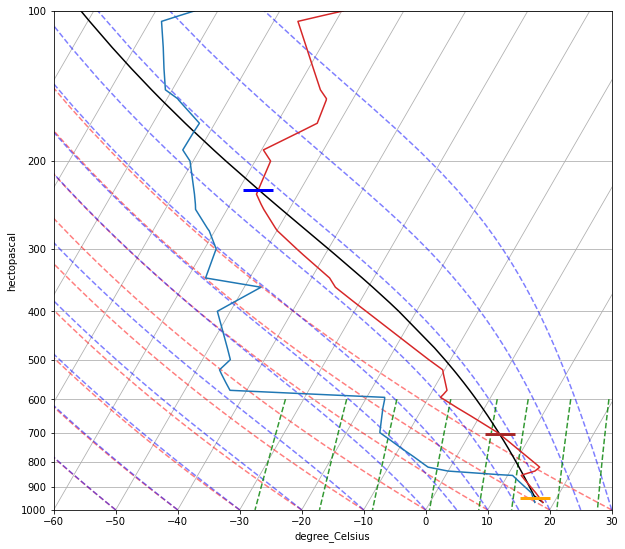

In [33]:
# Shade CAPE
# YOUR CODE GOES HERE

# Shade CIN
# YOUR CODE GOES HERE

# Redisplay the figure
fig

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

CAPE: 1169.354878115879 joule / kilogram	CIN: -9.514526707158492 joule / kilogram


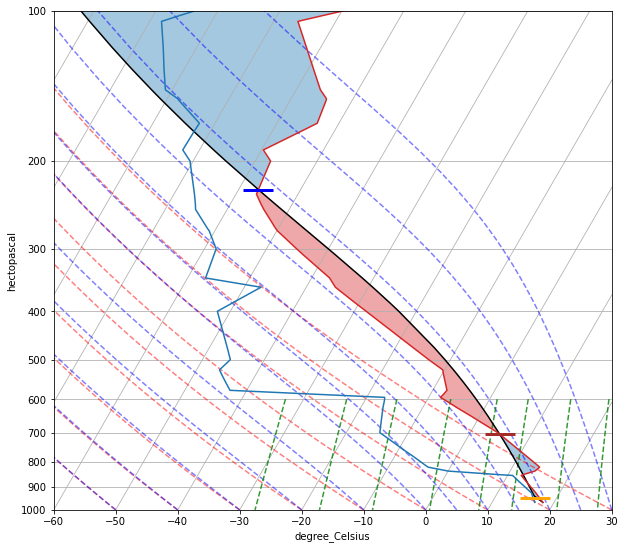

In [34]:
# %load solutions/skewt_cape_cin.py

# Cell content replaced by load magic replacement.
# Calculate surface based cape/cin
surface_cape, surface_cin = mpcalc.surface_based_cape_cin(sounding['pressure'],
                                                          sounding['temperature'],
                                                          sounding['dewpoint'])

# Print CAPE and CIN
print('CAPE: {}\tCIN: {}'.format(surface_cape, surface_cin))

# Shade CAPE
skew.shade_cape(sounding['pressure'],
                sounding['temperature'],
                sounding['profile'])

# Shade CIN
skew.shade_cin(sounding['pressure'],
               sounding['temperature'],
               sounding['profile'])

# Redisplay the figure
fig


<a href="#pagetop">Top</a>
<hr style="height:2px;">

<a name="hodograph"></a>
## 4.Plotting a Hodograph

Hodographs are a great way to look at wind shear - they are created by drawing wind vectors, all starting at the origin of a plot, and the connecting the vector tips. They are often thought of as a polar plot where the range rings (lines of constant radius) represent speed and the angle representes the compass angle of the wind.

In MetPy we can create a hodograph in a similar way to a skew-T - we create a hodograph object and attach it to an axes.

In [35]:
# Import the hodograph class
from metpy.plots import Hodograph

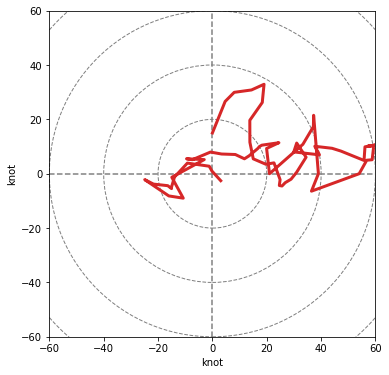

In [36]:
# Make a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create a hodograph
h = Hodograph(ax, component_range=60.)

# Add "range rings" to the plot
h.add_grid(increment=20)

# Plot the wind data
h.plot(sounding['u_wind'], sounding['v_wind'], color='tab:red')

We can even add wind vectors, which is helpful for learning/teaching hodographs.

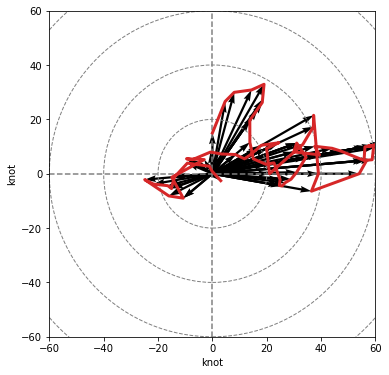

In [37]:
# Add vectors
h.wind_vectors(sounding['u_wind'], sounding['v_wind'])

# Redisplay figure
fig

This is great, but we generally don't care about wind shear for the entire sounding. Let's say we want to view it in the lowest 10km of the atmosphere. We can do this with the powerful, but complex `get_layer` function. Let's get a subset of the u-wind, v-wind, and windspeed.

In [38]:
(_, u_trimmed, v_trimmed,
 speed_trimmed, height_trimmed) = mpcalc.get_layer(sounding['pressure'],
                                                   sounding['u_wind'],
                                                   sounding['v_wind'],
                                                   sounding['speed'],
                                                   sounding['height'],
                                                   height=sounding['height'],
                                                   depth=10 * units.km)

Let's make the same hodograph again, but we'll also color the line by the value of the windspeed and we'll use the trimmed data we just created.

In [39]:
from metpy.plots import colortables
import numpy as np

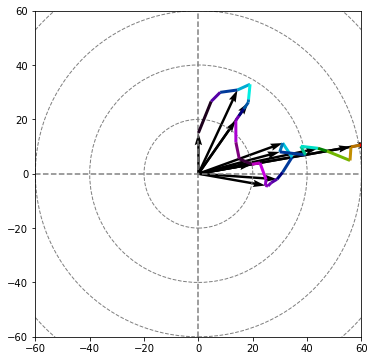

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

h = Hodograph(ax, component_range=60.)
h.add_grid(increment=20)

norm, cmap = colortables.get_with_range('ir_rgbv', np.nanmin(speed_trimmed.m),
                                        np.nanmax(speed_trimmed.m))

h.plot_colormapped(u_trimmed, v_trimmed, speed_trimmed,
                   cmap=cmap, norm=norm)
h.wind_vectors(u_trimmed[::3], v_trimmed[::3])

<div class="alert alert-success">
    <b>EXERCISE Part 1</b>:
    
In this exercise you'll create a hodograph that is colored by a variable that is not displayed - height above ground level. We generally wouldn't want to color this in a continuous fashion, so we'll make a hodograph that is segmented by height.
     <ul>
         <li>Make a variable to hold the height above ground level (subtract the surface height from the heights in the sounding).</li>
         <li>Make an list of boundary values that we'll use to segment the hodograph from 0-1, 1-3, 3-5, and 5-8 km. (Hint the array should have one more value than the number of segments desired.)</li>
         <li>Make a list of colors for each segment.</li>
    </ul>
</div>

In [41]:
# Calculate the height above ground level (AGL)
# YOUR CODE GOES HERE

In [42]:
# Make an array of segment boundaries - don't forget units!
# YOUR CODE GOES HERE

In [43]:
# Make a list of colors for the segments
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

In [44]:
# %load solutions/hodograph_preprocessing.py

# Cell content replaced by load magic replacement.
# Calculate the height above ground level (AGL)
sounding['height_agl'] = sounding['height'] - sounding['height'][0]

# Make an array of segment boundaries - don't forget units!
boundaries = [0, 1, 3, 5, 8] * units.km

# Make a list of colors for the segments
colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:olive']
